In [1]:
import sys
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from math import ceil, log2

from sklearn import decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from vae_dataset_generator import initial_population
from utils import load_data
from tree_encoder import JakowskiEncoder
from vae import CVAE

<h1> VAE </h1>

In [3]:
dataset = "iris"
depth = 4
train_size = 10000 
test_size = 5000
batch_size = 64
epochs = 100

# Load data
X_train, X_val, X_test, y_train, y_val, y_test = load_data(dataset)

n_features_in = X_train.shape[1]
n_classes = len(np.unique(y_train))

# Linear encoding
encoder = JakowskiEncoder(n_features=n_features_in, n_classes=n_classes)

# VAE dataset
#[train, test, train_nodes, train_leaves, train_depths, encoding_time]
init = initial_population(
                          X=X_train, 
                          y=y_train, 
                          mode="DT",
                          max_depth=depth,
                          train_size=train_size, 
                          test_size=test_size, 
                          encoder=encoder,
                          same_depth=False
                         )

max_depth = max(init[4])          # profondità massima degli alberi del training
vector_dim = init[0].shape[2]  # serve per il calcolo della latent_dim_size

vae_train = np.transpose(init[0], (0, 2, 1))
vae_test = np.transpose(init[1], (0, 2, 1))

# Scaling 
scalers = {}
for i in range(vae_train.shape[2]):
    scalers[i] = MinMaxScaler()
    vae_train[:, :, i] = scalers[i].fit_transform(vae_train[:, :, i]) 

for i in range(vae_test.shape[2]):
    vae_test[:, :, i] = scalers[i].transform(vae_test[:, :, i]) 

vae_train = vae_train.astype('float32')
vae_test = vae_test.astype('float32')
    
train_dataset = (tf.data.Dataset.from_tensor_slices(vae_train).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(vae_test).shuffle(test_size).batch(batch_size))
        
# Model
model = CVAE(input_shape=(vae_train.shape[1], vae_train.shape[2])) 
model.fit(epochs=epochs, train_dataset=train_dataset, test_dataset=test_dataset)

Epoch: 19, Test set ELBO: -22.086545944213867, time elapse for current epoch: 0.6693580150604248


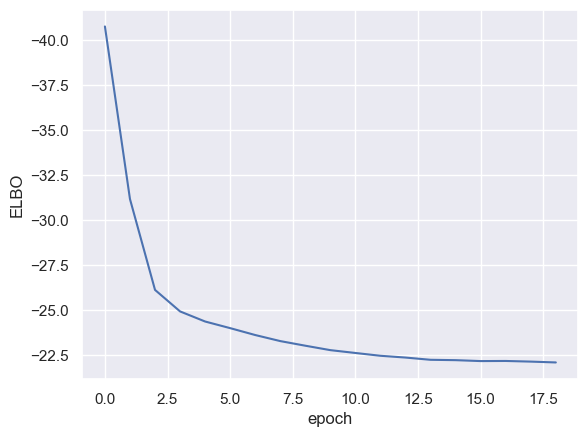

In [4]:
model.plot_loss()